In [1]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt
from skimage import io
import os
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import PCA


In [2]:
KEYPOINT_COLOR = (0, 255, 0) # Green

def vis_keypoints(image, keypoints, color=KEYPOINT_COLOR, diameter=5):
    image = image.copy()

    for (x, y) in keypoints:
        cv2.circle(image, (int(x), int(y)), diameter, (0, 255, 0), -1)
    
    return image
        

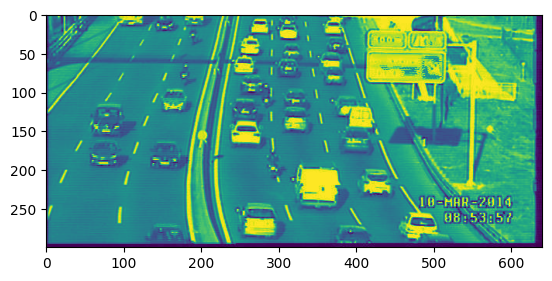

(300, 640)


In [43]:


image = cv2.imread('TRANCOS_v3/images/image-1-000001.jpg', cv2.IMREAD_GRAYSCALE)
image = image[180:480, 0:640]
plt.imshow(image)
plt.show()
print(image.shape)


In [4]:
def get_keypoints(keypoints_name):
    keypoints_file = open("TRANCOS_v3/images/"+keypoints_name +".txt", "r+")
    keypoints_list = keypoints_file.readlines()
    keypoints = []
    for keypoint_string in keypoints_list:
        keypoint_string.replace("\t", " ")
        keypoint_string.replace("\n", "")
        keypoint_string_list = keypoint_string.split()
        keypoints.append((int(keypoint_string_list[0]), int(keypoint_string_list[1])-180))
    return keypoints
    
keypoints_file = open("TRANCOS_v3/images/image-1-000001.txt", "r+")
keypoints_list = keypoints_file.readlines()
keypoints = []
for keypoint_string in keypoints_list:
    keypoint_string.replace("\t", " ")
    keypoint_string.replace("\n", "")
    keypoint_string_list = keypoint_string.split()
    keypoints.append((int(keypoint_string_list[0]), int(keypoint_string_list[1])-180))
vis_keypoints(image, keypoints)

array([[ 0, 15, 64, ...,  3,  4,  1],
       [ 0, 15, 63, ...,  3,  4,  1],
       [ 3, 19, 67, ...,  3,  4,  1],
       ...,
       [16, 13,  9, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  1,  1,  1],
       [ 6,  5,  5, ...,  2,  2,  2]], dtype=uint8)

In [5]:
box_size = 50

width, height = 640, 300
new_width = width // box_size * box_size
new_height = height // box_size * box_size

num_boxes_x = new_width // box_size
num_boxes_y = new_height // box_size

boxes = [[None] * num_boxes_x for i in range(num_boxes_y)]
bboxes = []
for i in range(num_boxes_x):
    for j in range(num_boxes_y):

        box_left = i * box_size
        box_upper = j * box_size
        box_right = (i + 1) * box_size
        box_lower = (j + 1) * box_size
        bboxes.append([box_left, box_upper, box_right, box_lower])
# print(len(boxes))

In [6]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=BOX_COLOR, thickness=thickness)
    
    # cut image from half of height
    # img = img[y_min:y_max, x_min:x_max]

    # ((text_width, text_height), _) = cv2.getTextSize(cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)   
    text_height = 2
    text_width = 2
    # cv2.rectangle(img, (x_min, y_min), (x_min, y_min), color=BOX_COLOR, -1)

    return img


def visualize(image, bboxes):
    img = image.copy()
    for bbox in bboxes:
        img = visualize_bbox(img, bbox)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)


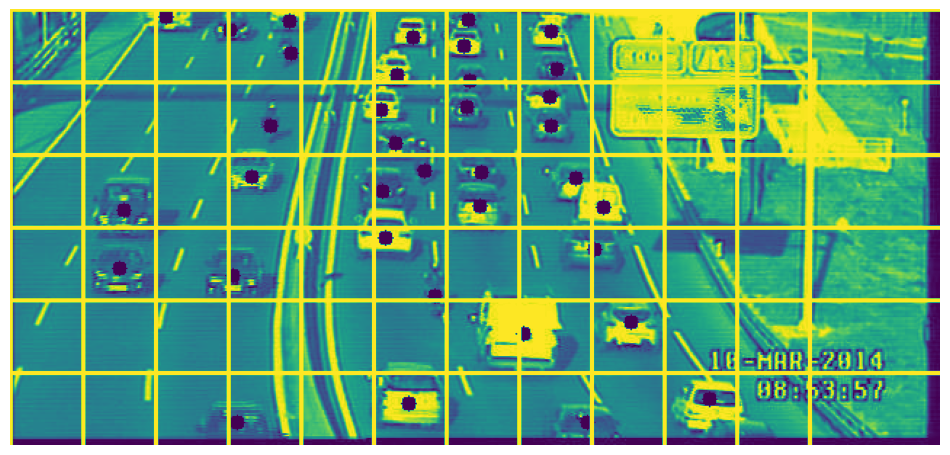

In [7]:
image = vis_keypoints(image, keypoints)
visualize(image, bboxes)
# print(image)


In [8]:
print(image.shape)
for i in range(len(bboxes)):
    # crop image using albumentations

    crop = A.Crop(x_min=bboxes[i][0], y_min=bboxes[i][1], x_max=bboxes[i][2], y_max=bboxes[i][3])
    cropped_image = crop(image=image)
    cropped_image = cropped_image['image']
    # print(cropped_image.shape)
    # plt.imshow(cropped_image, cmap="gray")
    # plt.show()

    

(300, 640)


In [9]:
# crop picture and check if there is a keypoint in the box

def check_keypoint_in_box(keypoints, box):
    for keypoint in keypoints:
        if keypoint[0] > box[0] and keypoint[0] < box[2] and keypoint[1] > box[1] and keypoint[1] < box[3]:
            return True
    return False
    
# check_keypoint_in_box(keypoints, bboxes[5])

In [10]:
# crop picture and find which box has a keypoint
def find_box_with_keypoint(keypoints, bboxes):
    has_keypoint = []
    for i in range(len(bboxes)):
        if check_keypoint_in_box(keypoints, bboxes[i]):
            has_keypoint.append(i)
            # plot box i with keypoint
    return has_keypoint

has_keyPoint = find_box_with_keypoint(keypoints, bboxes)
print(has_keyPoint)


[8, 9, 12, 18, 19, 20, 21, 23, 30, 31, 32, 33, 35, 36, 37, 38, 42, 43, 44, 46, 47, 50, 51, 52, 59]


In [11]:
# find number of keypoints in each box by using box coordinates
def find_number_of_keypoints_in_box(keypoints, bboxes):
    number_of_keypoints = []
    for i in range(len(bboxes)):
        number_of_keypoints.append(0)
        for keypoint in keypoints:
            if keypoint[0] > bboxes[i][0] and keypoint[0] < bboxes[i][2] and keypoint[1] > bboxes[i][1] and keypoint[1] < bboxes[i][3]:
                number_of_keypoints[i] += 1
    return number_of_keypoints
    


In [12]:
cropped_image_name_list = []
def make_boxes(image_name, bboxes):

    # image = cv2.imread('TRANCOS_v3/images/'+ image_name +'.jpg')
    image = cv2.imread('TRANCOS_v3/images/'+ image_name +'.jpg', cv2.IMREAD_GRAYSCALE)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image[180:480, 0:640]

    keypoints = get_keypoints(image_name)

    has_keyPoint = find_box_with_keypoint(keypoints, bboxes)
    # print(has_keyPoint)
    for i in range(len(bboxes)):

        crop = A.Crop(x_min=bboxes[i][0], y_min=bboxes[i][1], x_max=bboxes[i][2], y_max=bboxes[i][3])
        cropped_image = crop(image=image)
        cropped_image = cropped_image['image']

        # if i in has_keyPoint:    
        cropped_image = visualize_bbox(cropped_image, bboxes[i] , thickness=0)
        # plt.imshow(cropped_image)
        # plt.show()
        # print('number of key point in box : ' ,find_number_of_keypoints_in_box(keypoints, bboxes)[i])
        cropped_folder = 'C:/Users/ALI/Desktop/proposal/TRANCOS_v3/cropped_images' 

        if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)

        cv2.imwrite(os.path.join(cropped_folder,image_name + '_box_'+str(i+1)+'.jpg'), cropped_image)

            # make txt file for each box and write number of keypoints in it
            # txt_folder = 'C:/Users/ALI/Desktop/proposal/TRANCOS_v3/txt_files'
            # if not os.path.exists(txt_folder):
            #         os.makedirs(txt_folder)

        with open(os.path.join(cropped_folder,image_name + '_box_'+str(i+1)+'.txt'), 'w') as f:
                f.write(str(find_number_of_keypoints_in_box(keypoints, bboxes)[i]))
                f.close()
            
        cropped_image_name_list.append(image_name + '_box_'+str(i+1))

       
        with open(os.path.join(cropped_folder,image_name + '_box_'+str(i+1)+'_class.txt'), 'w') as f:
                if i in has_keyPoint:
                    f.write('1')
                else:
                    f.write('0')
                f.close()


                # print each keypoint coordinates in the box
        # for keypoint in keypoints:
        #         if keypoint[0] > bboxes[i][0] and keypoint[0] < bboxes[i][2] and keypoint[1] > bboxes[i][1] and keypoint[1] < bboxes[i][3]:
        #             print('keypoints cordinates ==> ','x : ' ,keypoint[0]-bboxes[i][0],',  y : ', keypoint[1]-bboxes[i][1])

                
    


In [13]:
# read image name from text file and save it in a list
image_name_file = open('TRANCOS_v3/image_sets/training.txt', 'r')
image_name_list = image_name_file.readlines()
image_name_file.close()


In [14]:
# remove /n from the end of each image name
for i in range(len(image_name_list)):
    image_name_list[i] = image_name_list[i].replace('\n','').replace('.jpg','')
# print(image_name_list)


In [15]:
for image_name in image_name_list:
    make_boxes(image_name, bboxes)

In [28]:
import math
def pred(y_pred , y_test):
    true=0
    all = len(y_pred)
    for i in range(len(y_pred)):
        if math.floor(y_pred[i]) == y_test[i]:
            true += 1
    return true/all

In [17]:
# make a list of all cropped images
image_list = []
image_keypoints_list = []
image_class_list = []
for cropped_image_name in cropped_image_name_list:
    image = cv2.imread('C:/Users/ALI/Desktop/proposal/TRANCOS_v3/cropped_images/'+cropped_image_name+'.jpg', cv2.IMREAD_GRAYSCALE)
    image = image.flatten()
    image_list.append(image)
    with open('C:/Users/ALI/Desktop/proposal/TRANCOS_v3/cropped_images/'+cropped_image_name+'.txt', 'r') as f:
        number_of_keypoints = f.read()
        f.close()
    image_keypoints_list.append(int(number_of_keypoints))
    with open('C:/Users/ALI/Desktop/proposal/TRANCOS_v3/cropped_images/'+cropped_image_name+'_class.txt', 'r') as f:
        class_number = f.read()
        f.close()
    image_class_list.append(int(class_number))
    


In [ ]:
def PCA1(X, n_components):
    # zero mean the data
    X -= X.mean(axis=0)
 
    cov = np.matmul(X.transpose(), X)

    # calculate the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov)

    # sort the eigenvalues and eigenvectors
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    # select the first n_components eigenvectors
    eigenvectors = eigenvectors[:, :n_components]
    # project the data
    X_pca = X.dot(eigenvectors)
    # X_pca.reshape(-1, 64, 64)
    return X_pca


In [18]:
image_list = np.array(image_list)
image_keypoints_list = np.array(image_keypoints_list)

pca = PCA(n_components=200)
image_list_pca = pca.fit_transform(image_list)

X_train, X_test, y_train, y_test = train_test_split(image_list_pca, image_keypoints_list, test_size=0.2)


In [ ]:
def normalization(data):
    data = (data - data.min()) / (data.max() - data.min())
    return data

In [ ]:
# define the model
class myLinearRegression:
    def __init__(self, lr=0.001, n_iters=500):
        self.lr = lr
        self.n_iters = n_iters
        self.theta_1 = None
        self.theta_0 = None

    def fit(self, x_train, y_train):
        m = len(x_train)
        self.theta_1 = np.random.randn(x_train.shape[1])
        self.theta_0 = np.random.randn(1)
        # cost_list = []
        for i in range(self.n_iters):
            cost = 0
            for j in range(m):
                y_pred = np.dot(self.theta_1, x_train[j]) + self.theta_0
                self.theta_1 = self.theta_1 - self.lr * (y_pred - y_train[j]) * x_train[j]
                self.theta_0 = self.theta_0 - self.lr * (y_pred - y_train[j])
                # cost += (y_pred - y_train[j]) ** 2
            # cost = cost / m
            # cost_list.append(cost)
            # print('theta_1 : ', theta_1)
            # print('theta_0 : ', theta_0)

    def predict(self, x_test):
         y_pred = np.dot(self.theta_1 , x_test.T) + self.theta_0
         return y_pred


In [ ]:
# normalize data
X_trn = normalization(X_train)
X_tst = normalization(X_test)


In [ ]:
reg = myLinearRegression()
reg.fit(X_trn, y_train)


In [22]:
# make predictions
predictions = reg.predict(X_tst)

print('accuracy = ' ,  pred(predictions , y_test)*100)

accuracy =  62.543073742246726


In [23]:
def estemate_number_of_car(image_name):
    
    show_image = cv2.imread('TRANCOS_v3/images/'+ image_name +'.jpg')
    show_image = show_image[180:480, 0:640]
    plt.imshow(show_image)
    plt.show()

    image = cv2.imread('TRANCOS_v3/images/'+ image_name +'.jpg', cv2.IMREAD_GRAYSCALE)
    image = image[180:480, 0:640]
    
    cropped_image_name_list = []

    for i in range(len(bboxes)):

        crop = A.Crop(x_min=bboxes[i][0], y_min=bboxes[i][1], x_max=bboxes[i][2], y_max=bboxes[i][3])
        cropped_image = crop(image=image)
        cropped_image = cropped_image['image']

        cropped_image = visualize_bbox(cropped_image, bboxes[i] , thickness=0)
        estemate_folder = 'C:/Users/ALI/Desktop/proposal/TRANCOS_v3/estemate/' 

        if not os.path.exists(estemate_folder):
                    os.makedirs(estemate_folder)

        cv2.imwrite(os.path.join(estemate_folder,image_name + '_box_'+str(i+1)+'.jpg'), cropped_image)

            
        cropped_image_name_list.append(image_name + '_box_'+str(i+1))

    # make a list of all stemate images
    image_list = []
    for cropped_image_name in cropped_image_name_list:
        image = cv2.imread(estemate_folder+cropped_image_name+'.jpg', cv2.IMREAD_GRAYSCALE)
        image = image.flatten()
        image_list.append(image)

    image_list = np.array(image_list)
    y_pred = reg.predict(image_list)

    pred = 0
    for i in range(len(y_pred)):
        if y_pred[i] > 0.5:
            pred = pred + math.ceil(y_pred[i])
        
    print('Estemate number of vehicle in image : ' , pred)
              
    

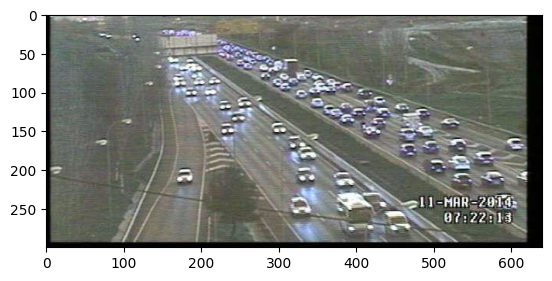

Estemate number of vehicle in image :  49


In [42]:
estemate_number_of_car('image-1-000105')

In [52]:
image_class_list = np.array(image_class_list)
X_train, X_test, y_train, y_test = train_test_split(image_list, image_class_list, test_size=0.2)


In [93]:
def make_diagonal(x):
    
    m = np.zeros((len(x), len(x)))
    for i in range(len(m[0])):
        m[i, i] = x[i]
    return m

class Sigmoid():
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))

    def gradient(self, x):
        return self.__call__(x) * (1 - self.__call__(x))

class LogisticRegression():

    def __init__(self, learning_rate=.1, gradient_descent=True):
        self.param = None
        self.learning_rate = learning_rate
        self.gradient_descent = gradient_descent
        self.sigmoid = Sigmoid()

    def _initialize_parameters(self, X):
        n_features = np.shape(X)[1]
        limit = 1 / math.sqrt(n_features)
        self.param = np.random.uniform(-limit, limit, (n_features,))

    def fit(self, X, y, n_iterations=4000):
        self._initialize_parameters(X)
        for i in range(n_iterations):
            y_pred = self.sigmoid(X.dot(self.param))
            if self.gradient_descent:
                self.param -= self.learning_rate * -(y - y_pred).dot(X)
            else:
                diag_gradient = make_diagonal(self.sigmoid.gradient(X.dot(self.param)))
                self.param = np.linalg.pinv(X.T.dot(diag_gradient).dot(X)).dot(X.T).dot(diag_gradient.dot(X).dot(self.param) + y - y_pred)

    def predict(self, X):
        y_pred = np.round(self.sigmoid(X.dot(self.param))).astype(int)
        return y_pred

In [ ]:

logreg = LogisticRegression()
logreg.fit(X_train, y_train)



In [95]:
y_pred = logreg.predict(X_test)

print('accuracy = ' ,  pred(y_pred , y_test)*100)


accuracy =  76.77463818056512
